# Monte Carlo Methods for Blackjack

In this notebook I wrote my own implementations of many Monte Carlo algorithms, in order to teach an agent how to play Blackjack.

### Explore BlackjackEnv

This is an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
import matplotlib
import numpy as np
import sys
import gym

%matplotlib inline

env = gym.make('Blackjack-v0')

print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

- STICK = 0
- HIT = 1

### Play Blackjack with a random policy.  
This is designed to visualize the output that is returned as the agent interacts with the environment.

In [2]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(f"State: {state}")
        action = env.action_space.sample()
        print(f"Action: {action}")
        state, reward, done, info = env.step(action)
        if action:
            print(f"New state: {state}")
        if done:
            print('End game! Reward: ', reward)
            print('You won!!!\n') if reward > 0 else print('You lost...\n')
            break

State: (15, 4, True)
Action: 0
End game! Reward:  -1.0
You lost...

State: (11, 10, False)
Action: 1
New state: (13, 10, False)
State: (13, 10, False)
Action: 1
New state: (20, 10, False)
State: (20, 10, False)
Action: 0
End game! Reward:  0.0
You lost...

State: (14, 10, False)
Action: 1
New state: (24, 10, False)
End game! Reward:  -1
You lost...



### Generate an episode from action-value function estimate 𝑄 following the epsilon-greedy policy

The function accepts as **input**:
- `env`: This is an instance of OpenAI Gym's Blackjack environment.
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `epsilon`: Value between 0 and 1, (probability of choosing a random action instead the Greedy action).
- `nA`: Number of actions the agent can choose.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [3]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

### Calculate the action probabilities corresponding to epsilon-greedy policy

The function accepts as **input**:
- `Q_s`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `epsilon`: Value between 0 and 1, (probability of choosing a random action instead the Greedy action).
- `nA`: Number of actions the agent can choose.

It returns as **output**:
- `policy_s`: This is a list containing the probability of taking each action.

In [4]:
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

### Update the action-value function estimate using the most recent episode

This algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `episode`: This is the number of episode that is generated through agent-environment interaction.
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1 inclusive.

The algorithm returns as output:
- `Q`: This is the updated Q.

In [5]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        # update Q using MC constant alpha
        # FORMULA -> Q(St|At) = Q(St|At) + alpha * (Gt - Q(St|At))
        Q[state][actions[i]] = Q[state][actions[i]] + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - Q[state][actions[i]])
    return Q

### MC Control: Constant-$\alpha$

This algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1 inclusive.

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [6]:
from collections import defaultdict


def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # fraction of num_episodes in order to have 0.1 <= epsilon < 1
    fraction = num_episodes // 10
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon, after 1kk episodes it remains static to 0.1
        epsilon = 1.0/((i_episode/fraction)+1)
        if i_episode > 1000000:
            epsilon = 0.1
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Obtain the estimated optimal policy and action-value function.

In [7]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 2500000, 0.005, gamma=0.85)

Episode 2500000/2500000.

### Plot the corresponding state-value function.

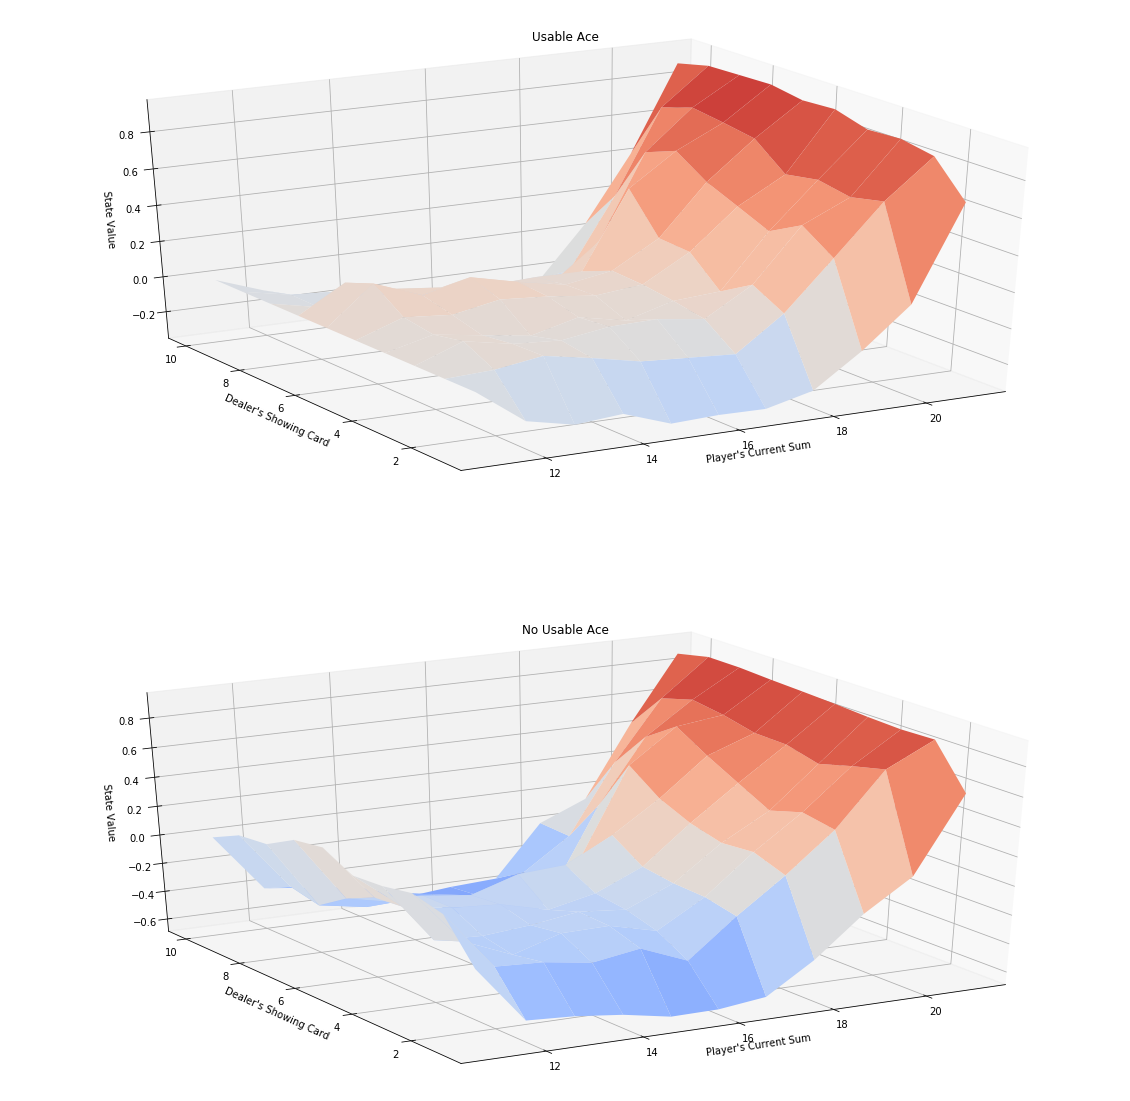

In [8]:
from plot_utils import plot_blackjack_values


# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Visualize the policy that is estimated to be optimal.

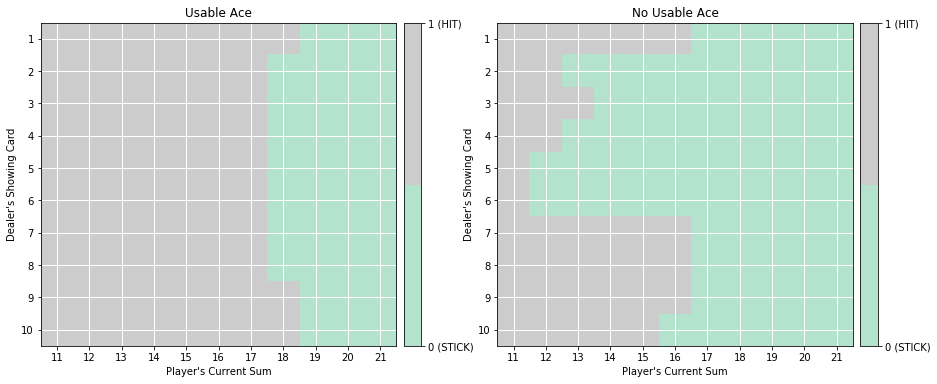

In [9]:
from plot_utils import plot_policy


# plot the policy
plot_policy(policy_alpha)

In the following picture there is the **true** optimal policy, is not exactly like the optimal policy found by the agent but it is very similar.

![True Optimal Policy](optimal.png)